In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
import gdown

from gensim.models import KeyedVectors, Word2Vec
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

import util_bagging as ubagging


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dropout, Dense, concatenate, BatchNormalization
from keras.optimizers import Adam

# Prueba Modelos de Ensamble y Redes Neuronales

Este archivo corresponde a la evaluación del módulo de ensamble y redes neuronales en el marco de la carrera de Data Science de la academia Desafío Latam. El trabajo fue realizado por Jorge Illanes Pareja

Se divide en dos partes una de procesamiento de lenguaje natural para clasificación y otra de modelos de regresión.

# NLP - Clasificación de Noticias Falsas

En esta primera sección clasificaremos si una noticia publicada es real o fake a través de un dataset clasificado, para eso utilizaremos distintos modelos y procesamiento de lenguaje natural a través de tokenizadores y modelos pre entrenados por google como Word2Vec.

Se utilizará una redes neuronal recurrente con LSTM para esta clasificación, mostrando sus métricas y una predicción de un set de validación, a parte de nuestro set de test.


## 1 - Carga de base de datos

Procedemos a la carga de la base de datos news1.csv, realizando un conteo con clases para ver el balance y luego poder dividir nuestro dataset para entrenamiento y testeo.

In [69]:
df = pd.read_csv('news1.csv', index_col=0)

In [70]:
df.head()

,Unnamed: 0,title,text,label
Unnamed: 0.1,,,,
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Nuestro dataset tiene dos columnas con texto, una de título y una de cuerpo (text), pensamos en una primera instancia juntar ambos o analizar solo la parte del texto, pero consideramos que ambos elementos por separado cumplen un rol interesante al crear una noticia, siendo el titutlar un elemento crucial a la hora de publicar noticias, sobre todo falsas, para generar una mayor atención, ser convicente, de manera que el cuerpo pase a segundo plano y sea compartida antes de que se haga un análisis profundo de consistencia sobre su falsedad.

Por otro lado el texto entregará características interesantes para que nuestro modelo clasifique correctamente, quizá hay palabras o situaciones que se repiten mucho más en una clasificación que en otra. Por ejemplo, exageraciones podrían ser mucho más frecuentes en noticias falsas que en reales. 

Para ello utilizaremos una red neuronal con dos ramas (entradas), y al final se combinarán para que el modelo pondere el título y el cuerpo por separado, pero teniendo en consideración ambas, a la hora de clasificar.

Preparamos el dataset

In [71]:
df['text'] = df['text'].astype(str)
df['title'] = df['title'].astype(str)

In [72]:
def remove_tags(txt):
    if isinstance(txt, str):
        return re.sub(r'<.*?>', '', txt)
    return txt

df['title'] = df['title'].apply(lambda txt: re.sub(re.compile('<.*?>'), '', txt))
df['text'] = df['text'].apply(lambda txt: re.sub(re.compile('<.*?>'), '', txt))

df['title'] = df['title'].apply(remove_tags)
df['text'] = df['text'].apply(remove_tags)

df['text'] = df['text'].str.strip()
df['text'] = df['text'].str.replace('\n', ' ')
df['text'] = df['text'].str.strip()

Contamos las clases de etiqueta `Fake` o `Real` para comprobar si nuestro dataset está balanceado

<Axes: xlabel='label'>

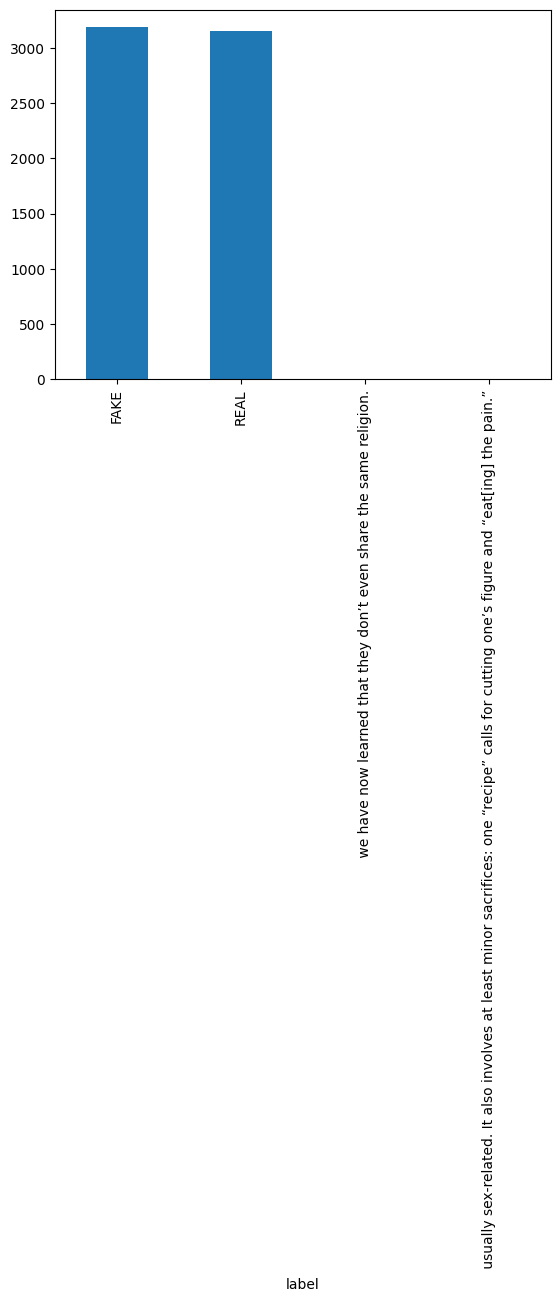

In [35]:
df['label'].value_counts().plot(kind='bar')

Limpiamos la etiqueta label de las clases que no corresponden a real o fake y mostramos la frecuencia de palabras a través de una nube de puntos para tener una pequeña idea de como se distribuyen esta en nuestro dataset, para titulo y texto

In [73]:
df['text'].tail()

Unnamed: 0.1
3257    Now we know why she didn't want those Wall Str...
3258    Catherine R. Squires is a professor of communi...
3259    Like his third-party forefathers, Gary Johnson...
3260    Gilad Atzmon  It occurred to me in recent year...
3261    Presumptive Republican nominee Donald Trump ha...
Name: text, dtype: object

Realizando un análisis exploratorio del contenido del texto y título nos encontramos con valores nan, que si bien el modelo podría clasificar dentro de sus palabras fuera de rango y no asignarlas , preferimos indicarlas con un token de no content, para ello utilizamos expresiones regulares para asegurarnos de cambiar solo los textos que dicen nan.

In [81]:
df['title'] = df['title'].replace(r'^\s*nan\s*$', '<NO_CONTENT>', regex=True)
df['text'] = df['text'].replace(r'^\s*nan\s*$', '<NO_CONTENT>', regex=True)

In [82]:
#ordena valores de text por longitud del text
df['text_len'] = df['text'].apply(len)
df = df.dropna(subset=['text'])
df.sort_values(by='text_len', ascending=True).head(20)

,Unnamed: 0,title,text,label,text_len
Unnamed: 0.1,,,,,
2650,8751,2009 FLASHBACK: “What If” Remixed,11/08/2016,FAKE,10
2650,8751,2009 FLASHBACK: “What If” Remixed,11/08/2016,FAKE,10
1664,5802,Alert News : Putins Army Is Coming For World W...,<NO_CONTENT>,FAKE,12
2244,6714,Is your promising internet career over now Vin...,<NO_CONTENT>,FAKE,12
710,8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,<NO_CONTENT>,FAKE,12
3641,7048,Comment software has been rolled back to old v...,<NO_CONTENT>,FAKE,12
2576,8055,A Reader Refers Us To Englishman Pat Condell O...,<NO_CONTENT>,FAKE,12
806,9314,Southern Poverty Law Center Targets Anti-Jihad...,<NO_CONTENT>,FAKE,12
710,8332,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,<NO_CONTENT>,FAKE,12


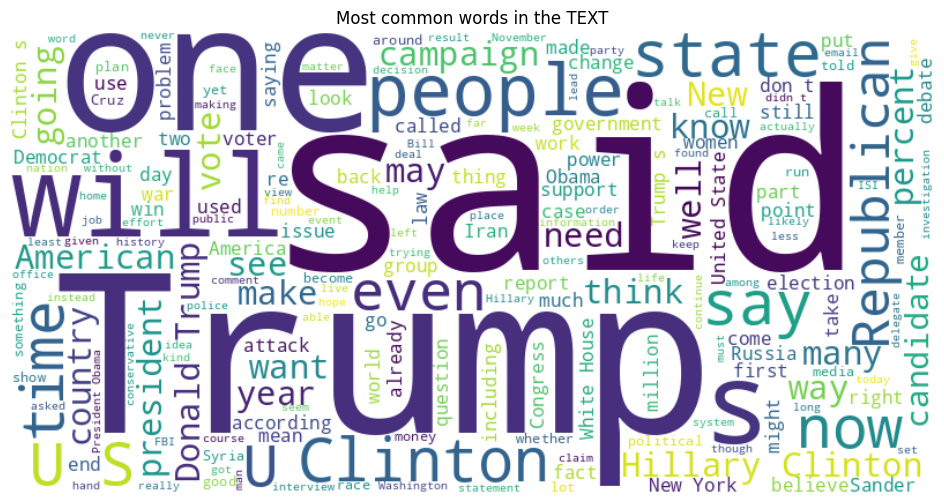

In [77]:
df = df[((df['label'] == 'FAKE') | (df['label'] == 'REAL'))]

text = ' '.join(df['text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.title('Most common words in the TEXT')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

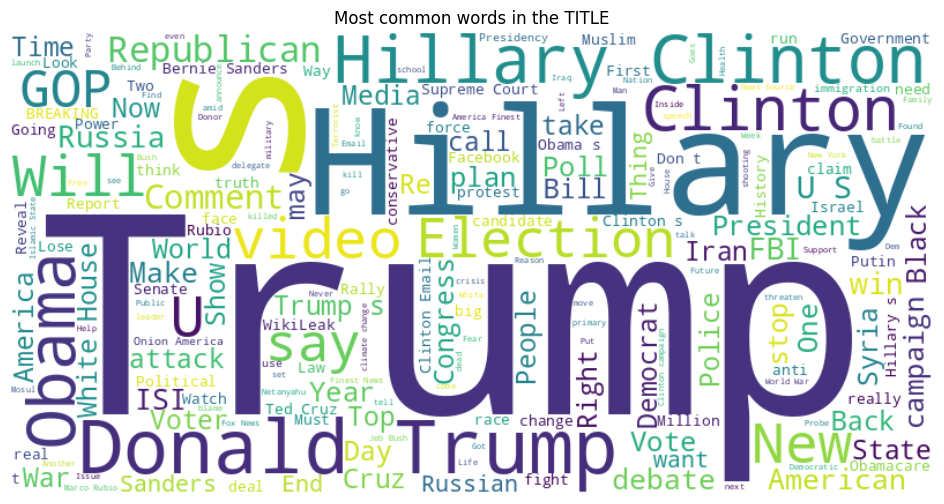

In [8]:
# Join all reviews into a single string
title = ' '.join(df['title'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(title)

# Display the generated image:
plt.figure(figsize=(12, 6))
plt.title('Most common words in the TITLE')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Dividimos el conjunto en datos de test y train

In [9]:
X = df[['title', 'text']]
y = df['label']
y = y.map({'FAKE': 1, 'REAL': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 2 Tokenizamos
Utilizamos un Word Embedding ya entrenado, lo descargamos desde el repositorio

In [10]:
url = 'https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK'
# Nombre del archivo descargado
nombre_archivo = 'archivo.bin'
# Descargar el archivo desde Google Drive
gdown.download(url, nombre_archivo, quiet=False)
# Cargar el archivo con KeyedVectors
word2vec_model_google = KeyedVectors.load_word2vec_format(nombre_archivo, binary=True)

Downloading...
From (original): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK
From (redirected): https://drive.google.com/uc?id=191stTi4bltaYgZX5l-i2mcxjcxjuMNPK&confirm=t&uuid=29f63f6f-10c3-4d5a-8bb6-370624bd2ec0
To: c:\Users\Jaip-PC\OneDrive\Documentos\Documentos\Machine Learning\Ensamble y DL\Prueba\archivo.bin
100%|██████████| 3.64G/3.64G [02:43<00:00, 22.3MB/s]


Tokenizamos nuestos dos campos a analizar, título y texto con las secuencias y máximo número de palabras indicadas en el desafío.

Tokenizamos train y test set para cada uno de estos dos campos, agregando padding para el análisis.

In [ ]:
MAX_SEQUENCE_LENGTH = 80
MAX_NUM_WORDS = 80000

tokenizer_title = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer_title.fit_on_texts(X_train['title'])

tokenizer_text = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
tokenizer_text.fit_on_texts(X_train['text'])

title_sequences = tokenizer_title.texts_to_sequences(X_train['title'])
text_sequences = tokenizer_text.texts_to_sequences(X_train['text'])

title_padded = pad_sequences(title_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
text_padded = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')


# Tokenización y padding para el conjunto de validación (X_test_title, X_test_text)
title_sequences_test = tokenizer_title.texts_to_sequences(X_test['title'])
text_sequences_test = tokenizer_text.texts_to_sequences(X_test['text'])

title_padded_test = pad_sequences(title_sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post',)
text_padded_test = pad_sequences(text_sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post',)

Creamos la matriz con los embedding para cada uno de los campos.

In [12]:
def get_embedding_matrix(word2vec_model, tokenizer, num_words, embedding_dim):

    num_words_ = min(num_words, len(tokenizer.word_index)) + 1
    embedding_matrix = np.zeros((num_words_, embedding_dim))
    print(num_words_)

    if isinstance(word2vec_model, Word2Vec):
        word2vec_model = word2vec_model.wv

    for word, i in tokenizer.word_index.items():
        if i >= num_words_:
            continue

        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
        else:
            embedding_matrix[i] = np.zeros(embedding_dim)

    return num_words_, embedding_matrix

In [13]:
embedding_dim = 300
num_words_title, embedding_matrix_title = get_embedding_matrix(word2vec_model_google, tokenizer_title, MAX_NUM_WORDS, embedding_dim)

num_words_text, embedding_matrix_text = get_embedding_matrix(word2vec_model_google, tokenizer_text, MAX_NUM_WORDS, embedding_dim)

7659
67218


Nuestra matriz de título tiene una longitud de 7659 y nuestro texto 67218, ambos menores a los 80000 máximos que habíamos puesto como tope.

## 3 Red Neuronal Recurrente LSTM

Crearemos un modelo con dos ramas, debido a que un título y un texto (cuerpo) tienen patrones lingüisticos distintos, por un lado los títulos suelen ser más cortos, conscisos y los cuerpos pasan a ser mas detallados y contienen contexto adicional, en la mayoría de los casos.

De esta manera, esperamos que nuestro modelo pueda ponderar adecuadamente estas diferencias.

Finalmente combinaremos las salidas de ambas capas para nuestra salida.

In [14]:
X_train_title = X_train['title']
X_train_text = X_train['text']

X_test_title = X_test['title']
X_test_text = X_test['text']


#Input
input_title = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_title')
input_text = Input(shape=(MAX_SEQUENCE_LENGTH,), name='input_text')

#Embeddings
embedding_title = Embedding(input_dim=num_words_title, 
                            output_dim=embedding_dim,
                            weights=[embedding_matrix_title],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(input_title)

embedding_text = Embedding(input_dim=num_words_text,
                           output_dim=embedding_dim,
                           weights=[embedding_matrix_text],
                           input_length=MAX_SEQUENCE_LENGTH,
                           trainable=False)(input_text)

lstm_title = LSTM(units=128, dropout=0.3, return_sequences=False)(embedding_title)

lstm_text = LSTM(units=128, dropout=0.3, return_sequences=False)(embedding_text)

concat = concatenate([lstm_title, lstm_text])

#Dense
dense_layer = Dense(16, activation='relu')(concat)
dropout_layer = Dropout(0.3)(dense_layer)

#Output
output = Dense(2, activation='sigmoid', name="output")(dropout_layer)

#Model
model = Model(inputs=[input_title, input_text], outputs=output)

#Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\Jaip-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_title         │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_text          │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 80, 300)   │  2,297,700 │ input_title[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 80, 300)   │ 20,165,400 │ input_text[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    219,648 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    219,648 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │         34 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,906,542 (87.38 MB)

 Trainable params: 443,442 (1.69 MB)

 Non-trainable params: 22,463,100 (85.69 MB)

In [15]:
history = model.fit([title_padded, text_padded], y_train, validation_data=([title_padded_test, text_padded_test], y_test), epochs=20, batch_size=32)

Epoch 1/20


c:\Users\Jaip-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_title', 'input_text']. Received: the structure of inputs=('*', '*')
  warnings.warn(


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6229 - loss: 0.6407 - val_accuracy: 0.7530 - val_loss: 0.5184
Epoch 2/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7450 - loss: 0.5130 - val_accuracy: 0.7955 - val_loss: 0.4269
Epoch 3/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8112 - loss: 0.4248 - val_accuracy: 0.8423 - val_loss: 0.3703
Epoch 4/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8173 - loss: 0.4094 - val_accuracy: 0.8409 - val_loss: 0.3928
Epoch 5/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8403 - loss: 0.3752 - val_accuracy: 0.8404 - val_loss: 0.3580
Epoch 6/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8594 - loss: 0.3246 - val_accuracy: 0.8309 - val_loss: 0.3673
Epoch 7/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8650 - loss: 0.3176 - val_accuracy: 0.8653 - val_loss: 0.3261
Epoch 8/20
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8810 - loss: 0.2895 - val_accuracy: 0.861

Con nuestra red ya entrenada, mostramos las métricas y curvas ROC y como cambian sus métricas a través de las distintas épocas.

In [16]:
yhat = model.predict([title_padded_test, text_padded_test])
yhat_class = np.where(yhat[:, 1] > 0.5, 1, 0)

print(classification_report(y_test, yhat_class))

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1010
           1       0.93      0.92      0.92      1083

    accuracy                           0.92      2093
   macro avg       0.92      0.92      0.92      2093
weighted avg       0.92      0.92      0.92      2093



0.971715897351508


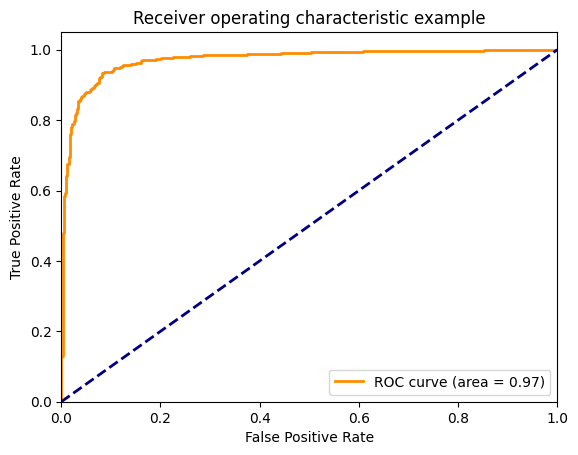

In [17]:
fpr, tpr, _ = roc_curve(y_test, yhat[:, 1])
roc_auc = auc(fpr, tpr)

print(roc_auc)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


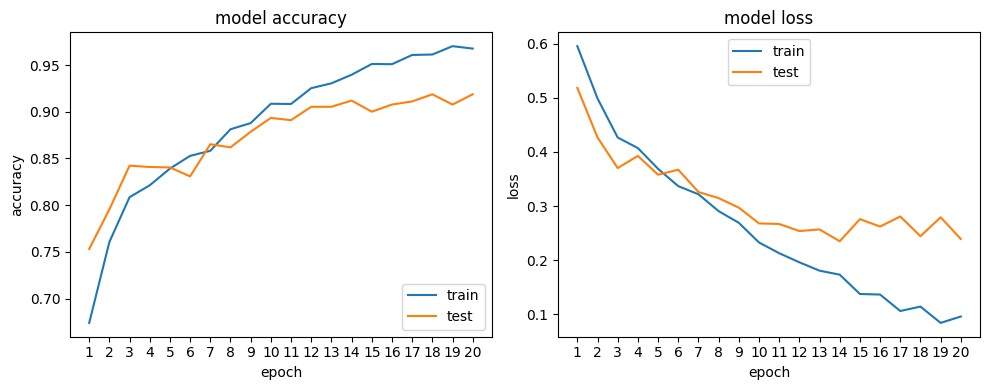

In [18]:
def viz_loss(history):
    epochs_ = len(history['accuracy'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(history['accuracy'])
    ax[0].plot(history['val_accuracy'])
    ax[0].set_xticks(np.arange(epochs_), np.arange(1, epochs_+1))
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='lower right')


    # summarize history for loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_xticks(np.arange(epochs_), np.arange(1, epochs_+1))
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper center')

    plt.tight_layout()
    plt.show()

viz_loss(history.history)

Aquí podemos apreciar que desde la época 12 en adelante, el modelo no presenta mejoras para el set de testeo y se va sobreajustando para el set de entrenamiento. De existir mejoras al parecer, serían leves. Lo mismo se puede observa en la pérdida pero desde otro punto de vista, aunque la época de inflexión aquí es la 14, en donde el modelo empieza a oscilar y empeorar sus métrias de pérdida.

En este sentido sería ideal poder detenernos antes y no sobreentrenar al modelo para empeorar resultados.

## 4 Predicciones

Tomando nuestro dataset de validación, que contiene 7 noticias, utilizaremos el modelo para predecir si la noticia es real o fake para luego compararla con su etiqueta real

In [19]:
news_pred = pd.read_csv('news_pred.csv')
news_pred.head()

,title,text,label
0,At least 12 dead after terror attack at Paris ...,Gunmen stormed the offices of the satirical ne...,REAL
1,World leaders' personal chefs sample Indian ma...,World leaders' personal chefs sample Indian ma...,FAKE
2,An Open Letter to Black South African Police O...,Tweet Widget by Black Power Front \nWith stude...,FAKE
3,Gay man finds it in himself to tolerate religi...,Gay man finds it in himself to tolerate religi...,FAKE
4,US Spy Chief: Asking North Korea To Stop Nuke ...,"Get short URL 0 27 0 0 On Tuesday, National In...",FAKE


In [20]:
def preprocess_text_data(tokenizer_title, tokenizer_text, X_data, max_sequence_length=80):
    """
    Preprocesa las secuencias de texto (tanto title como text) para ser usadas en el modelo.
    
    Parámetros:
    - tokenizer_title: El tokenizer entrenado para 'title'.
    - tokenizer_text: El tokenizer entrenado para 'text'.
    - X_data: DataFrame con las columnas 'title' y 'text'.
    - max_sequence_length: Longitud máxima de la secuencia (por defecto 80).
    
    Retorna:
    - title_padded: Secuencias de 'title' preprocesadas y con padding.
    - text_padded: Secuencias de 'text' preprocesadas y con padding.
    """
    # Tokenización de los textos (title y text)
    title_sequences = tokenizer_title.texts_to_sequences(X_data['title'])
    text_sequences = tokenizer_text.texts_to_sequences(X_data['text'])
    
    # Padding de las secuencias
    title_padded = pad_sequences(title_sequences, maxlen=max_sequence_length, padding='post')
    text_padded = pad_sequences(text_sequences, maxlen=max_sequence_length, padding='post')
    
    return title_padded, text_padded

In [21]:
X_predict = news_pred[['title', 'text']]
y_pred = news_pred['label']
y_pred = y_pred.map({'FAKE': 1, 'REAL': 0})
title_padded_new, text_padded_new = preprocess_text_data(tokenizer_title, tokenizer_text, X_predict)

yhat_pred = model.predict([title_padded_new, text_padded_new])

yhat_pred_class = np.where(yhat_pred[:, 1] > 0.5, 1, 0)

print(classification_report(y_pred, yhat_pred_class))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         4

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



Hemos obtenido un 100% de accuracy para estos datos de validación, procedemos a mostrar todas las clasificaciones y finalmente una noticia al azar predicha correctamente.

In [22]:
news_pred['prediction'] = yhat_pred_class
news_pred['prediction'] = news_pred['prediction'].map({1: 'FAKE', 0: 'REAL'})
news_pred.head(10)

,title,text,label,prediction
0,At least 12 dead after terror attack at Paris ...,Gunmen stormed the offices of the satirical ne...,REAL,REAL
1,World leaders' personal chefs sample Indian ma...,World leaders' personal chefs sample Indian ma...,FAKE,FAKE
2,An Open Letter to Black South African Police O...,Tweet Widget by Black Power Front \nWith stude...,FAKE,FAKE
3,Gay man finds it in himself to tolerate religi...,Gay man finds it in himself to tolerate religi...,FAKE,FAKE
4,US Spy Chief: Asking North Korea To Stop Nuke ...,"Get short URL 0 27 0 0 On Tuesday, National In...",FAKE,FAKE
5,The Devastating Consequences Of A 'Small' Rise...,"More Floods, More Drought Inevitable. How Bad ...",REAL,REAL
6,"Cost, logistics of Obama immigration plan rais...",President Obama’s executive action sparing mil...,REAL,REAL


In [23]:
print(news_pred['title'][0])
print(news_pred['text'][0])

At least 12 dead after terror attack at Paris newspaper office (+video)
Gunmen stormed the offices of the satirical newspaper Charlie Hebdo on Wednesday. French President Francois Hollande called the deadly assault a terrorist attack.

Why is Angela Merkel calling for a ban on the full Islamic veil?

Masked gunmen shouting "Allahu akbar!" stormed the Paris offices of a satirical newspaper Wednesday, killing 12 people including the editor and a cartoonist before escaping. It was France's deadliest terror attack in at least two decades.

With a manhunt on, French President Francois Hollande called the attack on the Charlie Hebdo weekly, whose caricatures of the Prophet Muhammed have frequently drawn condemnation from Muslims, "a terrorist attack without a doubt." He said several other attacks have been thwarted in France "in recent weeks."

There was no immediate claim of responsibility for the attack.

France raised its security alert to the highest level and reinforced protective measu

Esta noticia es real, lo que el modelo predijo correctamente. Nos llama la atención que hay citas de personas, hay un vídeo, se comentan muchos detalles del hecho ocurrido y muchos nombres de personas participantes en el desarrollo y relato de la noticia. Pueden ser elementos que aporten a esa clasificación. Por otro lado no se identifican palabras exageradas en el cuerpo de la noticia.

# Regresión - Predicción de shares para noticias

En esta sección desarrollaremos distintos modelos para predecir el número de veces que será compartida una noticia. El dataset OnlineNewsPopularity contiene muchas variables que serán analizadas y utilizadas en el modelo.

Si bien queremos desarrollar un modelo predictivo, hay features que podrían no aportarnos información relevante para la predicción en sí, porque son datos a los cuales no se podría acceder una vez publicada, como el `timedelta`. Esto, debido a que el tiempo transcurrido desde que se publica el artículo a la obtención de los datos es en realidad un dato instantaneo, y una nueva noticia siempre tendrá 0 días cuando se publica.

Luego de la producción de los modelos exigidos para el desafío, propondremos algunas mejoras propuestas que podrían ser desarrolladas en una continuación de este desafío.

## 5 Predicción de Shares

Cargamos nuestro dataset, quitamos los espacios en blanco de las columnas y revisamos la integridad del dataset.

In [24]:
news_popularity = pd.read_csv('OnlineNewsPopularity.csv')
news_popularity.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


Eliminaremos los espacios en blanco en las cabeceras de los datos

In [25]:
new_columns = []
for column in list(news_popularity.columns):
    column = column.strip()
    new_columns.append(column)

news_popularity.columns = new_columns    

In [26]:
news_popularity.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

Ya no poseen espacios en blanco ni al inicio ni al final de las columnas, es un detalle, pero así es evitamos errores en posibles análisis al escribir los nombres de las columnas.

In [27]:
for column in news_popularity.columns:
    if news_popularity[column].isnull().sum() > 0:
        print("Hay valores nulos en la columna", column)
        print(column, news_popularity[column].isnull().sum())

Nuestro ciclo iterativo no arroja valores nulos para ningún campo.

In [28]:
news_popularity.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


Los estadísticos descriptivmos muetran algunas inconsitencias en los valores máximos, por ejemplo en n_tokens, n_non_stop_words, n_non_stop_unique_tokens, así como en otras. Nos encargaremos de ellos más adelante.

## 6 - Outliers target
Revisaremos como se comportan los outliers para nuestra variable target. Graficaremos violin plots para también ver la distribución de la variable.

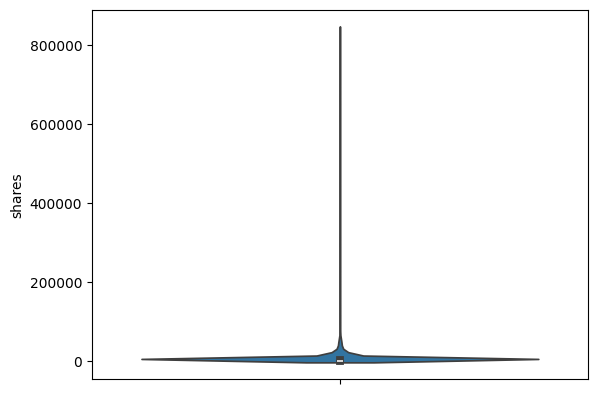

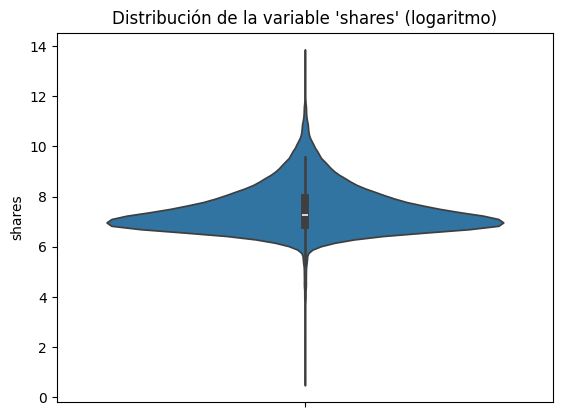

In [33]:
sns.violinplot(news_popularity['shares'])
plt.show()
plt.title("Distribución de la variable 'shares'")
sns.violinplot(np.log1p(news_popularity['shares']))
plt.title("Distribución de la variable 'shares' (logaritmo)")
plt.show()

Notamos que la variable shared tiene bastantes outliers, incluso cuando esta es transformada mediante un logaritmo, para esto eliminaremos los valores. Un 5% inferior y superior muestra un buen rendimiento en la eliminaciónd e outliers según prueba en distintos valores.

Datos eliminados 3984


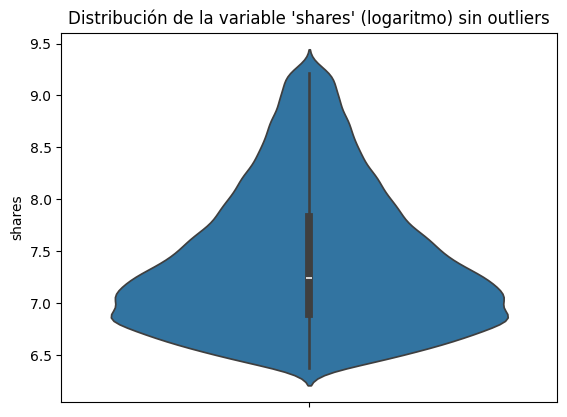

C:\Users\Jaip-PC\AppData\Local\Temp\ipykernel_33448\594018656.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_popularity_subset['shares'] = np.log1p(news_popularity_subset['shares'])


In [34]:
q_sup = news_popularity['shares'].quantile(0.95)
q_inf = news_popularity['shares'].quantile(0.05)

news_popularity_subset = news_popularity[(news_popularity['shares'] < q_sup) & (news_popularity['shares'] > q_inf)]
print("Datos eliminados", news_popularity.shape[0] - news_popularity_subset.shape[0])
news_popularity_subset.shape

sns.violinplot(np.log1p(news_popularity_subset['shares']))
plt.title("Distribución de la variable 'shares' (logaritmo) sin outliers")
plt.show()

news_popularity_subset['shares'] = np.log1p(news_popularity_subset['shares'])

Creemos que la variable en su transformación lineal a través de un logaritmo es una buena idea para reducir los valores extremadamente altos que quedan en el dataset y que pueden ser considerados dentro de un rango de tolerancia como datos posibles.

In [35]:
news_popularity_subset['shares'].describe()

count    35660.000000
mean         7.417883
std          0.675204
min          6.373320
25%          6.893656
50%          7.244942
75%          7.824446
max          9.278092
Name: shares, dtype: float64

Estos estadísticos comprueba la idea de que los valores están mejor distribuidos para un modelamiento.

### Correlaciones
Procedemos a realizar un análisis de correlaciones absolutas. Serán eliminadas todas aquellas cuyo valor sea superior a 0.7 o inferior a -0.7. Esto para evitar la multiexplicabilidad de las variables y reducir nuestro modelo, ya que dos variables pueden explicar e influenciar al modelo de la misma manera.

<Axes: >

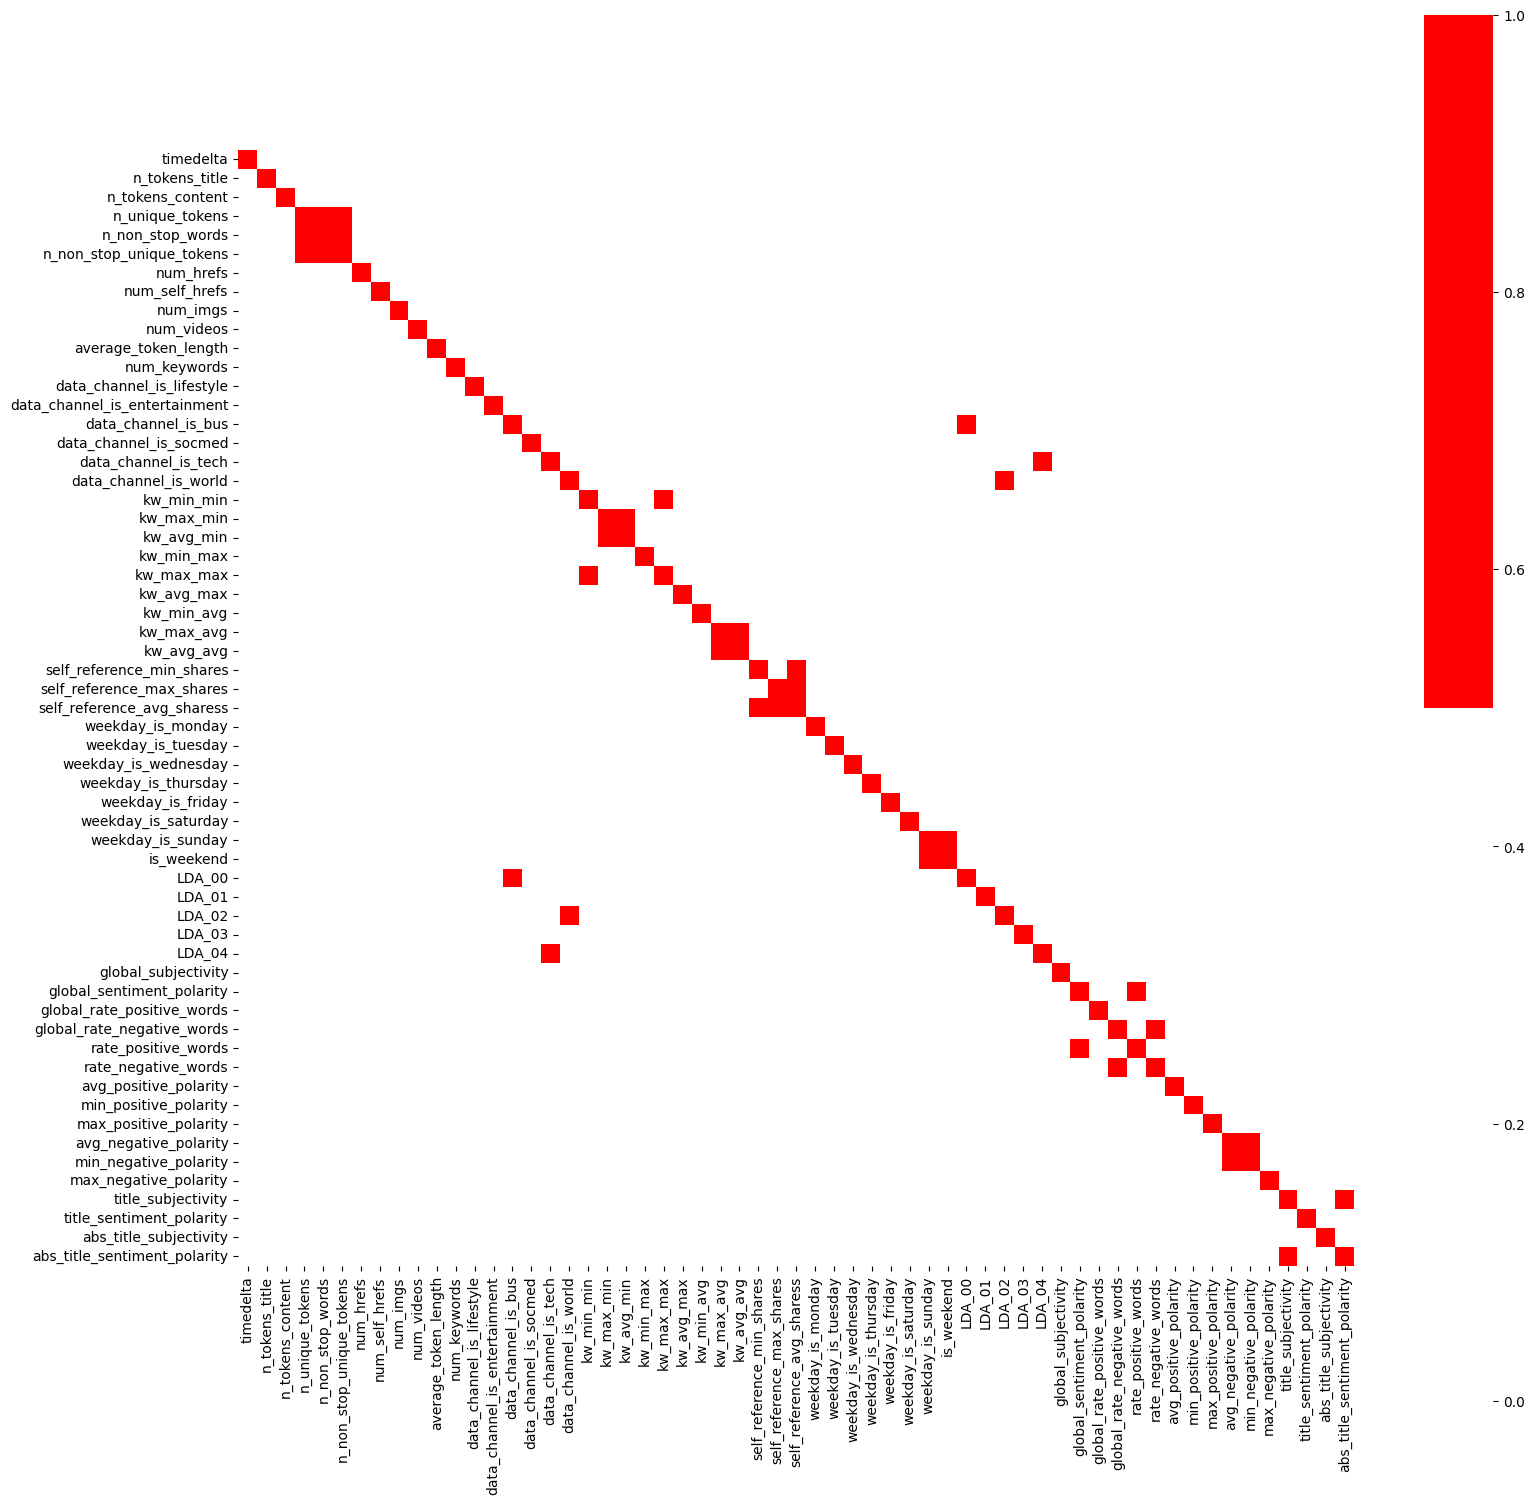

In [36]:

X = news_popularity_subset.drop(columns=['url', 'shares'])
corr = np.abs(X.corr()) > 0.7
plt.figure(figsize=(18, 18))
cmap = ListedColormap(['white', 'red'])
sns.heatmap(corr, annot=False, cmap=cmap, cbar=True, square=True)

Como el análisis a mano podría ser tedioso y probocar errores por la gran cantidad de variables, automatizaremos la búsqueda de estas parejas de features que arrojan positivo en nuestro test de correlación.

In [37]:
#Lista de los valores de correlación mayores a 0.7
mask = np.triu(np.ones(X.corr().shape), k=1).astype(bool)
masked_corr = X.corr().where(mask)
corr_list = masked_corr[(np.abs(X.corr()) > 0.7) & (X.corr() != 1)].stack().reset_index().sort_values(["level_0", "level_1"], ascending=True)
corr_list

,level_0,level_1,0
14,avg_negative_polarity,min_negative_polarity,0.749097
3,data_channel_is_bus,LDA_00,0.776684
4,data_channel_is_tech,LDA_04,0.754364
5,data_channel_is_world,LDA_02,0.835487
13,global_rate_negative_words,rate_negative_words,0.780516
12,global_sentiment_polarity,rate_positive_words,0.728151
8,kw_max_avg,kw_avg_avg,0.796418
7,kw_max_min,kw_avg_min,0.942323
6,kw_min_min,kw_max_max,-0.855204
2,n_non_stop_words,n_non_stop_unique_tokens,0.999582


In [38]:
corr_list['level_0'].value_counts()

level_0
n_unique_tokens               2
avg_negative_polarity         1
data_channel_is_bus           1
data_channel_is_tech          1
data_channel_is_world         1
global_rate_negative_words    1
global_sentiment_polarity     1
kw_max_avg                    1
kw_max_min                    1
kw_min_min                    1
n_non_stop_words              1
self_reference_max_shares     1
self_reference_min_shares     1
title_subjectivity            1
weekday_is_sunday             1
Name: count, dtype: int64

In [39]:
corr_list['level_1'].value_counts()


level_1
n_non_stop_unique_tokens        2
self_reference_avg_sharess      2
min_negative_polarity           1
LDA_00                          1
LDA_04                          1
LDA_02                          1
rate_negative_words             1
rate_positive_words             1
kw_avg_avg                      1
kw_avg_min                      1
kw_max_max                      1
n_non_stop_words                1
abs_title_sentiment_polarity    1
is_weekend                      1
Name: count, dtype: int64

Tenemos 3 campos que se repiten dos veces, por lo que debiesen tener mayor explicabilidad, por lo tanto, intentarmeos mantener esos 3 campos e ir eliminando los otros hasta que ya no tengamos correlaciones superiores a 0.7 en nuestro modelo.

In [40]:
#Obtiene los campos que se repiten más de una vez en la lista de correlaciones y lo pasa a lista
keep_columns = pd.concat([corr_list['level_0'].value_counts()[(corr_list['level_0'].value_counts()>1)], corr_list['level_1'].value_counts()[(corr_list['level_1'].value_counts()>1)]]).index

keep_columns = list(keep_columns)

to_delete_columns = []
for feature in corr_list['level_0'].unique():
    if feature not in keep_columns:
        to_delete_columns.append(feature)
        
to_delete_columns

['avg_negative_polarity',
 'data_channel_is_bus',
 'data_channel_is_tech',
 'data_channel_is_world',
 'global_rate_negative_words',
 'global_sentiment_polarity',
 'kw_max_avg',
 'kw_max_min',
 'kw_min_min',
 'n_non_stop_words',
 'self_reference_max_shares',
 'self_reference_min_shares',
 'title_subjectivity',
 'weekday_is_sunday']

Obtenemos la lista de columnas a eliminar y procedemos a su eliminación. Luego de esto, mostramos nuevamente nuestro mapa de correlación

<Axes: >

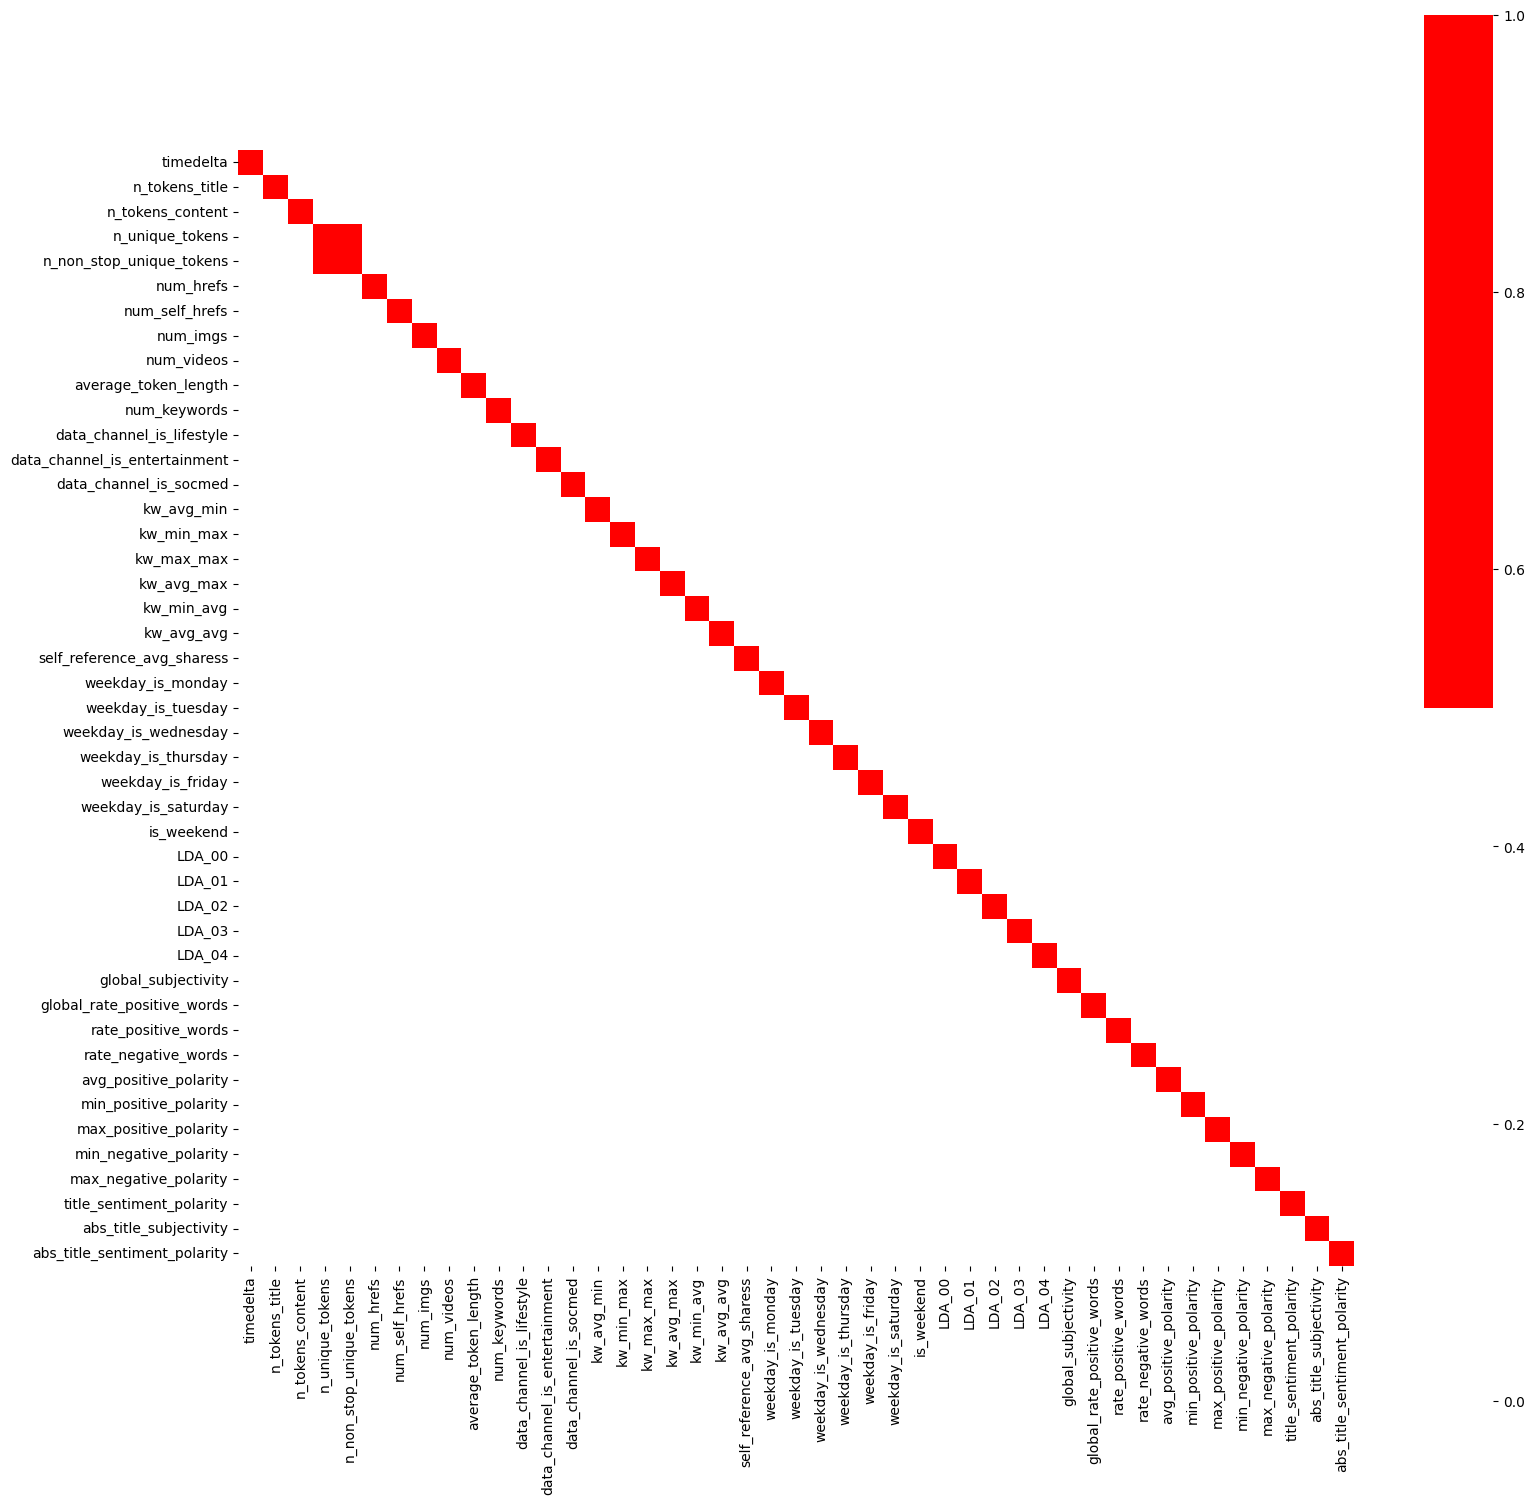

In [41]:
news_popularity_filtered = news_popularity_subset.drop(columns=to_delete_columns)

X = news_popularity_filtered.drop(columns=['url', 'shares'])
y = news_popularity_filtered['shares']

corr = np.abs(X.corr()) > 0.7
plt.figure(figsize=(18, 18))
sns.heatmap(corr, annot=False, cmap=cmap, cbar=True, square=True)

Notamos que aun queda una variable superior a 0.7 en correlación absoluta, así que eliminamos y procedemos al modelo.

In [42]:
news_popularity_filtered = news_popularity_filtered.drop(columns='n_non_stop_unique_tokens')

Finalmente, nuestro dataset contendrá las siguientes columnas para su análisis.

In [43]:
news_popularity_filtered.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords',
       'data_channel_is_lifestyle', 'data_channel_is_entertainment',
       'data_channel_is_socmed', 'kw_avg_min', 'kw_min_max', 'kw_max_max',
       'kw_avg_max', 'kw_min_avg', 'kw_avg_avg', 'self_reference_avg_sharess',
       'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday',
       'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday',
       'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04',
       'global_subjectivity', 'global_rate_positive_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'min_negative_polarity', 'max_negative_polarity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'shares'],


## 7 Distribución de variables

Al ser muchas variables, graficarlas todas y analizarlas de forma bivariada puede tomar tiempo, pero es algo que se debiese realizar, además del riguroso análisis de outliers para cada una de las variables. Sin embargo, por temas académicos, solo realizaremos el análisis para 4 variables.

Después de un pequeño análisis, filtramos nuestro dataset

In [ ]:
news_popularity_filtered = news_popularity_filtered[news_popularity_filtered['n_unique_tokens'] < 1]
X = news_popularity_filtered.drop(columns=['url', 'shares'])

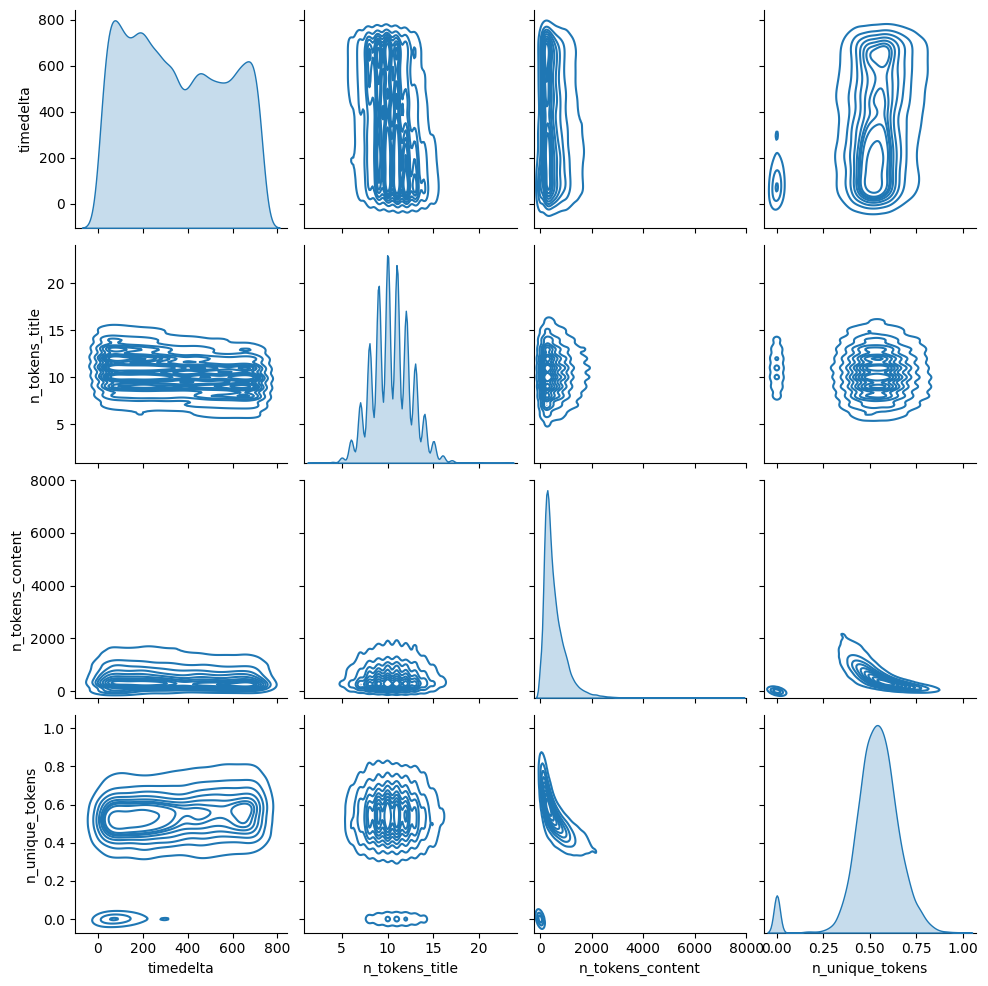

In [45]:
#Muestra las primeras 4 columnas del dataframe
sns.pairplot(X.iloc[:, :4], kind = 'kde')

Las distribuciones se observan sin mayor problema, revisaremos que pasa en n_tokens_content pues su distribución es un poco extraña.

<Axes: >

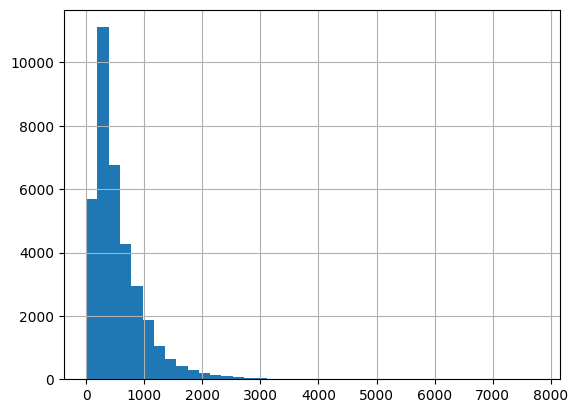

In [46]:
news_popularity_filtered['n_tokens_content'].hist(bins=40)

Vemos que hay valores altos, pero no son muchos. Aplicaremos una transformación logarítimica para esta variable debido a su distribución asimétrica.

<Axes: >

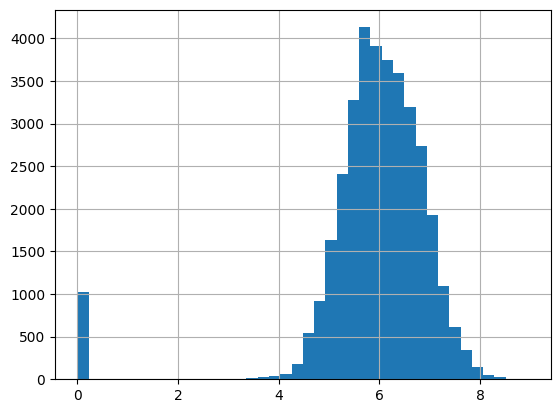

In [47]:
news_popularity_filtered['n_tokens_content'] = np.log1p(news_popularity_filtered['n_tokens_content'])
news_popularity_filtered['n_tokens_content'].hist(bins=40)

In [48]:
pd.set_option('display.max_columns', None)
news_popularity_filtered.describe(percentiles=[0.05,.75 ,0.90, 0.99])


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_socmed,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_avg_avg,self_reference_avg_sharess,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_rate_positive_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,min_negative_polarity,max_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.00000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000,35659.000000
mean,351.587818,10.397571,5.902074,0.529859,10.845509,3.333352,4.502089,1.218234,4.552666,7.224516,0.052609,0.172916,0.060321,307.283872,13589.296279,754157.121624,258959.193529,1119.614791,3112.864735,6254.056385,0.165849,0.18475,0.186292,0.182619,0.145489,0.063602,0.135001,0.188629,0.138996,0.217070,0.215581,0.239725,0.442552,0.039731,0.684456,0.286688,0.353145,0.094832,0.756252,-0.520440,-0.107161,0.071502,0.341919,0.154488,7.417848
std,213.955639,2.112389,1.241802,0.135736,11.258889,3.861302,8.236735,4.015533,0.830941,1.910870,0.223256,0.378180,0.238085,503.295662,57998.192041,211813.366174,133995.206224,1130.847017,1230.611734,24193.822651,0.371950,0.38810,0.389348,0.386359,0.352598,0.244047,0.341729,0.265899,0.217589,0.282202,0.290427,0.291990,0.115380,0.017409,0.188813,0.155472,0.103233,0.070440,0.246602,0.289972,0.094464,0.263035,0.188789,0.224573,0.675180
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,0.018182,0.018182,0.018182,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,6.373320
5%,43.000000,7.000000,4.672829,0.350905,1.000000,0.000000,0.000000,0.000000,4.162162,4.000000,0.000000,0.000000,0.000000,37.600000,0.000000,69100.000000,28923.928571,0.000000,1796.306907,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020034,0.020011,0.020018,0.020027,0.020240,0.276434,0.012658,0.363636,0.000000,0.199823,0.033333,0.400000,-1.000000,-0.250000,-0.333333,0.000000,0.000000,6.551080
50%,332.000000,10.000000,6.025866,0.538160,7.000000,3.000000,1.000000,0.000000,4.664251,7.000000,0.000000,0.000000,0.000000,235.448750,1500.000000,843300.000000,244050.000000,1041.222222,2861.739439,2200.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033414,0.033344,0.040007,0.040000,0.050000,0.452429,0.039106,0.714286,0.277778,0.358001,0.100000,0.800000,-0.500000,-0.100000,0.000000,0.500000,0.000000,7.244942
75%,540.000000,12.000000,6.580639,0.606987,13.000000,4.000000,4.000000,1.000000,4.854693,9.000000,0.000000,0.000000,0.000000,357.000000,7800.000000,843300.000000,329769.047619,2055.670409,3564.839013,5100.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.253014,0.149361,0.335041,0.344412,0.417499,0.506949,0.050360,0.800000,0.380952,0.409904,0.100000,1.000000,-0.300000,-0.050000,0.142857,0.500000,0.250000,7.824446
90%,660.000000,13.000000,6.999422,0.674757,23.000000,6.000000,13.0000

Si bien hay valores que parecen ser extremos, como el número de imágenes o videos, consideramos dejarlos puesto que pueden ser indicadores claves a la hora de poder clasificar una noticia como real o fake. Por otro lado los kw son indicadores de los vectores de las palabras y no indican necesariamente un cuantificable numérico, más bien, son un categórico. Procedemos a definir y entrenar los modelos con nuestro dataset ya preparado.

## 8 - Random Forest

Separamos nuestros datos para entrenamiento y test para luego entrenar un modelo de RandomForest con una búsqueda de hiperparámetros con GridSearch, además de Cross Validatión según lo indicado en el desafío.

In [49]:
X = news_popularity_filtered.drop(columns=['url', 'shares'])
y = news_popularity_filtered['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,)

In [50]:
rfr = RandomForestRegressor()
params = {
    'n_estimators': np.linspace(100,300,10, dtype=int),
    'max_depth': np.linspace(2,15,10, dtype=int),
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(rfr, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)
yhat = grid.predict(X_test)

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 233}
-0.38603569723155745
RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=233)


Mostramos las métricas para nuestro set de testeo.

In [51]:
mean_absolute_percentage_error
print(mean_squared_error(y_test, yhat))
print(mean_absolute_error(y_test, yhat))
print(r2_score(y_test, yhat))
print(mean_absolute_percentage_error(y_test, yhat))


0.39331677984419444
0.49932301441408483
0.14469298192298063
0.06623932244332095


Obtenemos un rendimiento muy pobre en nuestro modelo, sin embargo, aquí están las features más explicativas para este modelo.


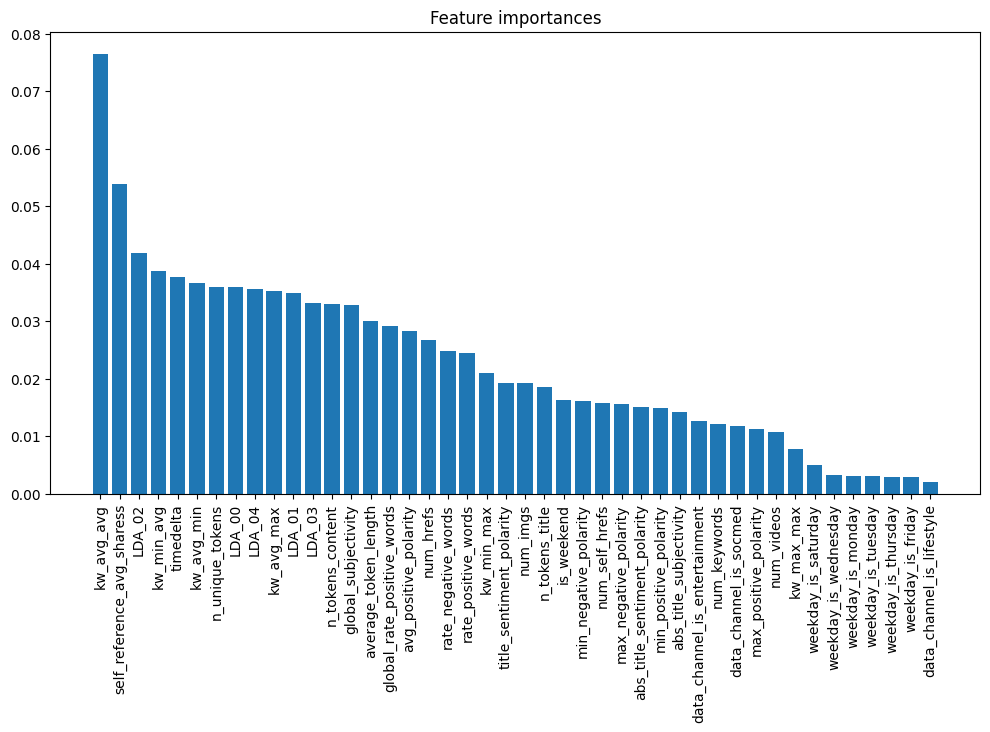

In [52]:
#feature importance
importances = grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices], rotation=90)

plt.show()


## 9 - Red Neuronal Fully Connected

Implementamos una red neuronal con 4 capas ocultas y Dropout

In [53]:
#Modelo de red neuronal Fully Connected
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Hiperparámetros
input_dim = X_train.shape[1]  
neurons_per_layer = [1024, 1024, 512, 64]  
dropout_rate = 0.25  
learning_rate = 0.02  
activation_hidden = 'relu' 
activation_output = 'linear' 


model = Sequential()

model.add(Dense(neurons_per_layer[0], activation=activation_hidden, input_dim=input_dim))
model.add(BatchNormalization())  
model.add(Dropout(dropout_rate))  


for neurons in neurons_per_layer[1:]:
    model.add(Dense(neurons, activation=activation_hidden))
    model.add(BatchNormalization()) 
    model.add(Dropout(dropout_rate))  

model.add(Dense(1, activation=activation_output)) 

model.summary()


c:\Users\Jaip-PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1024)           │        46,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,663,873 (6.35 MB)

 Trainable params: 1,658,625 (6.33 MB)

 Non-trainable params: 5,248 (20.50 KB)

Compilamos el modelo

In [54]:
model.compile(optimizer='adam',
              loss='mse',  
              metrics=['mae'],) 

In [55]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 29.2592 - mae: 4.7014 - val_loss: 0.5132 - val_mae: 0.5717
Epoch 2/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.0065 - mae: 1.1107 - val_loss: 0.4562 - val_mae: 0.5274
Epoch 3/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3634 - mae: 0.9220 - val_loss: 0.4501 - val_mae: 0.5152
Epoch 4/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0462 - mae: 0.8083 - val_loss: 0.4275 - val_mae: 0.5104
Epoch 5/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8756 - mae: 0.7436 - val_loss: 0.4329 - val_mae: 0.5157
Epoch 6/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7866 - mae: 0.7044 - val_loss: 0.4165 - val_mae: 0.5076
Epoch 7/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7272 - mae: 0.6797 - val_loss: 0.4157 - val_mae: 0.5126
Epoch 8/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6859 - mae: 0.6586 - val_loss: 0.4123 - val_mae: 0.5192
Epoch 9/20
747/747 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - l

Predecimos y mostramos las métricas del modelo.

In [56]:
yhat = model.predict(X_test)
print(mean_squared_error(y_test, yhat))
print(r2_score(y_test, yhat))
print(mean_absolute_error(y_test, yhat))
print(mean_absolute_percentage_error(y_test, yhat))

368/368 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
0.4102953939245556
0.10777127269433606
0.4962636692221557
0.06499375999919604


## 10 - Extreme Gradient Boosting Regressor

Como tercer modelo aplicamos un xgb regressor con búsqueda de hiperparámetros e imprimimos las métricas

In [57]:
#XGBoost
from xgboost import XGBRegressor
xgb = XGBRegressor()

params={
    'n_estimators': [100, 120, 150, 200, 300],
    'learning_rate': [0.008, 0.07, 0.009, 0.01, 0.02],
    'subsample': np.linspace(0.05, 1, 5),
    'scale_pos_weight': np.linspace(0.8, 0.9, 2)    
}

grid = GridSearchCV(xgb, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)




{'learning_rate': 0.02, 'n_estimators': 300, 'scale_pos_weight': 0.8, 'subsample': 0.7625}
-0.38034315796061197
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


In [58]:
yhat = grid.predict(X_test)
print(mean_squared_error(y_test, yhat))
print(r2_score(y_test, yhat))
print(mean_absolute_error(y_test, yhat))
print(mean_absolute_percentage_error(y_test, yhat))


0.3882758669947305
0.15565495547358565
0.49237936282288064
0.06521131865885041


## 11 - Bagging

Finalmente, como cuarto modelo, implementaremos Bagging heterogéneo con ElasticNet, DecisionTree y SVR con kernel rbf para 20 muestras bootstrap utilizando un script proporcionado por la academia para el bagging.

In [ ]:
X = news_popularity_filtered.drop(columns=['url', 'shares'])
y = news_popularity_filtered['shares']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=X.columns).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


estimators = [
    ElasticNet(alpha=0.5, l1_ratio=0.2), 
    DecisionTreeRegressor(max_depth=5),
    SVR(kernel='rbf'),
]

T = 20

trained_model, yhat_test, yhat_out, idx_oob = ubagging.bagging_het(X_train, y_train, T, estimators, X_test)

Mostramos las métricas del modelo.

In [60]:
print(mean_squared_error(y_test, yhat_out))
print(r2_score(y_test, yhat_out))
print(mean_absolute_error(y_test, yhat_out))
print(mean_absolute_percentage_error(y_test, yhat_out))

0.4975157310218543
-0.08189814966774711
0.5185301125632894
0.06618789751487458


Evaluamos nuestro modelo, calculando los estimadores para cada uno de los modelos y luego un promedio de esos rendimientos en general agrupados por el tipo de estimador utilizado.

In [64]:
mean_mape = []
mean_mae = []
mean_mse = []
for index_model in range(len(trained_model)):
    mape = mean_absolute_percentage_error(y_test, yhat_test[:,index_model])
    mean_mape.append(mape)
    mae = mean_absolute_error(y_test, yhat_test[:,index_model])
    mean_mae.append(mae)
    mse = mean_squared_error(y_test, yhat_test[:,index_model])
    mean_mse.append(mean_squared_error(y_test, yhat_test[:,index_model]))

mean_mape_df = pd.DataFrame(
                            {
        'Modelo': trained_model,
        'MAPE': mean_mape,
        'MSE': mean_mse,
        'MAE': mean_mae
    }
)


In [65]:
mean_mape_df

,Modelo,MAPE,MSE,MAE
0,SVR(),0.065150,0.427105,0.499324
1,"ElasticNet(alpha=0.5, l1_ratio=0.2)",0.073540,0.459927,0.553432
2,DecisionTreeRegressor(max_depth=5),0.068781,0.423085,0.518369
3,SVR(),0.064992,0.425792,0.497909
4,"ElasticNet(alpha=0.5, l1_ratio=0.2)",0.073886,0.459863,0.555155
5,SVR(),0.064953,0.427608,0.497939
6,SVR(),0.065163,0.430705,0.499670
7,"ElasticNet(alpha=0.5, l1_ratio=0.2)",0.073888,0.459863,0.555168
8,DecisionTreeRegressor(max_depth=5),0.068603,0.423539,0.517889
9,DecisionTreeRegressor(max_depth=5),0.069095,0.426175,0.520734


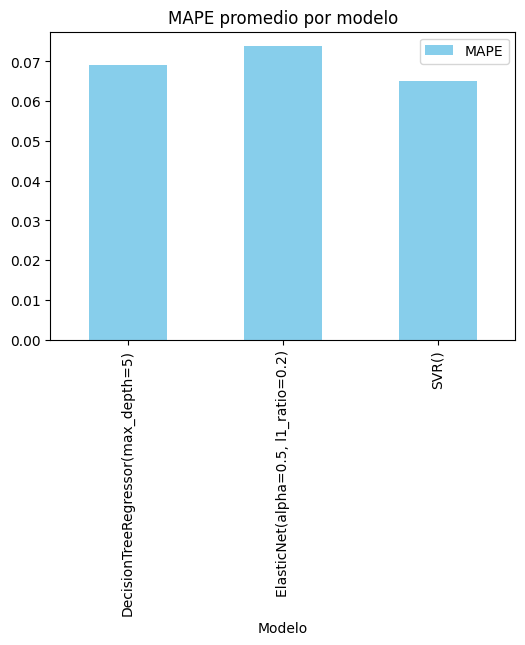

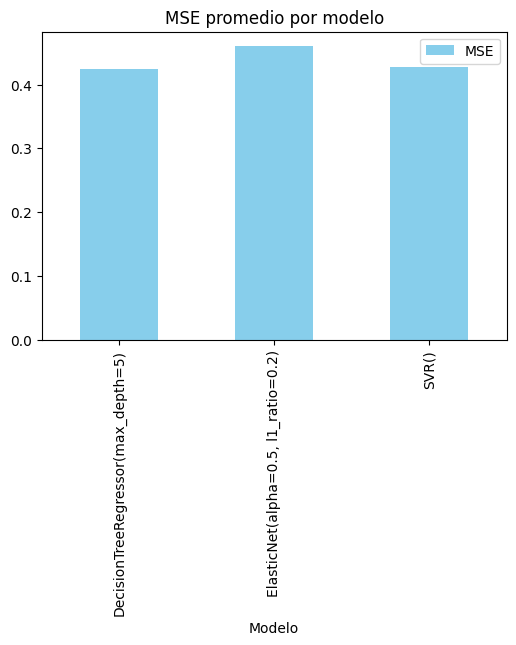

In [66]:
mean_mape_df['Modelo'] = mean_mape_df['Modelo'].astype(str)

mean_mape_df.pivot_table(index='Modelo', values='MAPE', aggfunc='mean').plot(kind='bar', color='skyblue', figsize=(6, 4))
plt.title('MAPE promedio por modelo')
plt.show()
mean_mape_df.pivot_table(index='Modelo', values='MSE', aggfunc='mean').plot(kind='bar', color='skyblue', figsize=(6, 4))
plt.title('MSE promedio por modelo')
plt.show()



In [67]:
mean_mape_df.pivot_table(index='Modelo', values=['MAPE', 'MSE', 'MAE'], aggfunc='mean')

,MAE,MAPE,MSE
Modelo,,,
DecisionTreeRegressor(max_depth=5),0.520069,0.068986,0.424776
"ElasticNet(alpha=0.5, l1_ratio=0.2)",0.554623,0.073779,0.459871
SVR(),0.498663,0.065063,0.427562


En general, nuestro modelo con mejor rendimiento para nuestro bagging heterogéneo fue el modelo de SVR, seguido por el modelo de DecisionTreeRegressor y finalmente el modelo de ElasticNet, aunque en general, los modelos presentan poca variación en su rendimiento.

En caso de querer mejorar el bagging propondríamos realizar una pequeña búsqueda de hiperparámetros con los modelos y aumentar la proporción de SVR con un 40%, DecisionTree con 35% y ElasticNet con 25%, con los parámetros optimizados.

## Conclusiones.

En general, nuestros modelos encontrados tienen rendimientos similares, quien obtuvo un menor MAPE fue la red neuronal Fully conected con un 0.064. Considerando que el peor desempeño fue de 0.066 los modelos obtenidos no presentan una mayor variación en esa métrica.

Por otro lado, si analizamos el mse, el modelo xgb es quien obtiene un menor valor, y por lo tanto, mejor rendimiento, con 0.38, donde el valor más alto es 0.49 de los modelos de bagging.
